In [1]:
# DATA CLEANING AND PREPARATION STAGE (PANDAS)

import pandas as pd

df = pd.read_csv("imdb_top_1000.csv")

print(df.head(1)) # the first lines
print(df.shape) # number of rows and columns
print(df.columns) # sütun isimleri (column names)
print(df.info())
print(
    "\n The number of missing values \n", df.isna().sum()
)

df.columns = df.columns.str.strip() # Clear unnecessary gaps and format errors

# Fill missing values in the "Certificate" column with "unknown"
df["Certificate"] = df["Certificate"].fillna(
    "unknown"
)

# Fill missing values with the median of the column
df["Meta_score"] = df["Meta_score"].fillna(
    df["Meta_score"].median() # is preferred not to be affected by outlier values (Meta_score = 0-100)
)

# Convert the "Gross" column to numbers (remove commas, replace missing values with 0)
df["Gross"] = df["Gross"].astype(str).str.replace(",", "").astype(float) # Remove commas and convert to float
df["Gross"] = df["Gross"].fillna(
    df["Gross"].median()
)

# object -> numeric and setting errors to NaN
df["Released_Year"] = pd.to_numeric( # Convert to numeric
    df["Released_Year"],
    errors="coerce" # If conversion fails, set as NaN
)

# Filling NaN's with the average
mean_year = df["Released_Year"].mean()
df["Released_Year"] = df["Released_Year"].fillna(
    mean_year
)

# numeric -> int
df.Released_Year = df.Released_Year.astype('int64')

# object -> category
colomuns = ["Certificate", "Genre", "Director"]
for i in colomuns:
    df[i] = df[i].astype("category")

# object -> string -> int
df["Runtime"] = df["Runtime"].astype(str).str.replace(" min", "").astype('int64')

print(
    "\nAfter cleaning, data info:\n", df.dtypes
)
print(
    "\n The number of missing values \n", df.isna().sum()
)

                                         Poster_Link  \
0  https://m.media-amazon.com/images/M/MV5BMDFkYT...   

               Series_Title Released_Year Certificate  Runtime  Genre  \
0  The Shawshank Redemption          1994           A  142 min  Drama   

   IMDB_Rating                                           Overview  Meta_score  \
0          9.3  Two imprisoned men bond over a number of years...        80.0   

         Director        Star1           Star2       Star3           Star4  \
0  Frank Darabont  Tim Robbins  Morgan Freeman  Bob Gunton  William Sadler   

   No_of_Votes       Gross  
0      2343110  28,341,469  
(1000, 16)
Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate',
       'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director',
       'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   


RandomForestRegressor R²: 0.69
RandomForestRegressor RMSE: 64623309


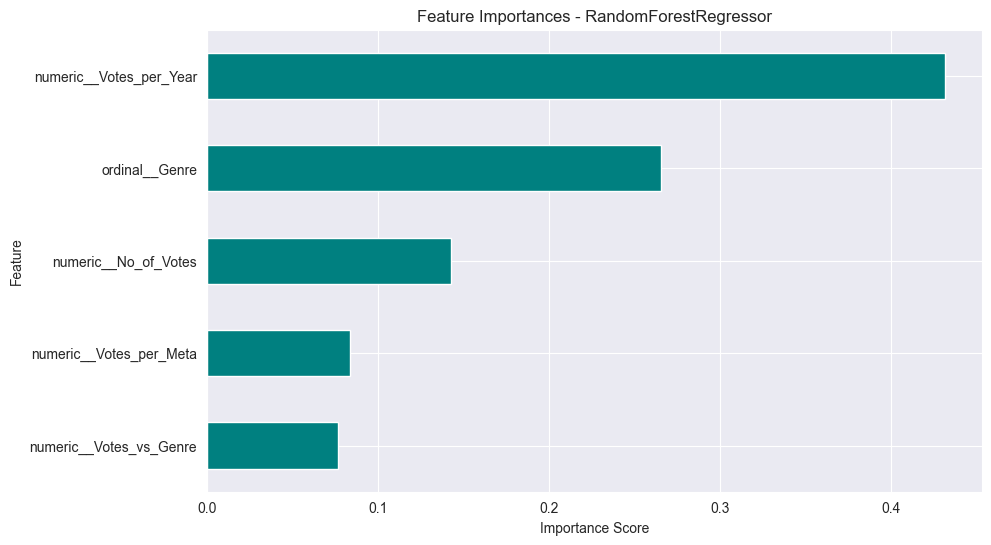

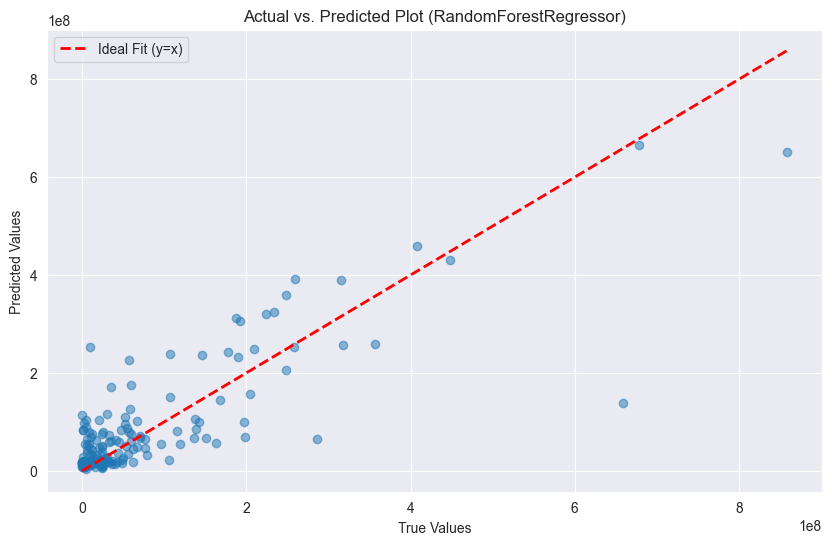

In [2]:
# PREDICT GROSS WITH RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Feature Engineering Part
df["Votes_per_Year"] = df["No_of_Votes"] / (2025 - df["Released_Year"] + 1) # Filmin oy sayısını, piyasada kaldığı yaklaşık süreye göre normalize eder
df["Votes_per_Meta"] = df["No_of_Votes"] / (df["Meta_score"] + 1) # Oy sayısını, kalite puanına göre oranlar
df["Genre_Avg_Votes"] = df.groupby("Genre", observed=True)["No_of_Votes"].transform("mean") # Her bir film türü için tüm filmlerin ortalama oy sayısını hesaplar ve bu değeri o türdeki her satıra atar
df["Votes_vs_Genre"] = df["No_of_Votes"] / df["Genre_Avg_Votes"] # Filmin kendi oy sayısını, ait olduğu türün ortalama oy sayısına böler

X = df[
    [
        "No_of_Votes", "Genre", "Votes_per_Year", "Votes_per_Meta", "Votes_vs_Genre"
    ]
].copy()
y = df["Gross"]

# Encoding Groups
numeric_cols = ["No_of_Votes", "Votes_per_Year", "Votes_per_Meta", "Votes_vs_Genre"]
ordinal_cols = ["Genre"]

# ColumnTransformer Pipeline
preprocess = ColumnTransformer( # veri ön işleme (preprocessing) adımlarını birden fazla sütuna aynı anda uygular
    transformers=[
        ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ordinal_cols),
        ("numeric", "passthrough", numeric_cols) # passthrough = sayısal sütunlara ayar yapılmadan bir sonraki adıma geçilmesini sağlar
    ]
)

# Final Model Pipeline
model = Pipeline( # veri ön işleme adımlarını ve modeli birbirine bağlar
    steps=[ # Pipeline'ın hangi sıralamayla çalışacağını belirler, isim-nesne çiftlerinden oluşan bir listedir
        ("preprocess", preprocess),
        (
            "rf", # bu etiketler, Pipeline içindeki adımlara dışarıdan erişip onları ayarlamak için kullanılır
            RandomForestRegressor(
                max_depth=8,
                random_state=42
            )
        )
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)

# Forecasting and Performance
y_pred = model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print(
    "\nRandomForestRegressor R²:",
    round(r2_score(y_test, y_pred), 2)
)
print(
    "RandomForestRegressor RMSE:",
    round(rmse_lr)
)

# Feature Importance Graph
rf = model.named_steps["rf"]
feature_names = model.named_steps["preprocess"].get_feature_names_out()

importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values()

plt.figure(figsize=(10, 6))
importances.plot(kind="barh", color="teal")
plt.title("Feature Importances - RandomForestRegressor")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Actual vs. Predicted Plot Graph
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)

# Veri aralığını belirleme
max_val = max(np.max(y_test), np.max(y_pred))
min_val = min(np.min(y_test), np.min(y_pred))
plt.plot(
    [min_val, max_val], # X-ekseni verileri
    [min_val, max_val], # Y-ekseni verileri
    'r--', linewidth=2,
    label='Ideal Fit (y=x)'
)

plt.title("Actual vs. Predicted Plot (RandomForestRegressor)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()


GradientBoostingRegressor R²: 0.76
RMSE: 56110686.54


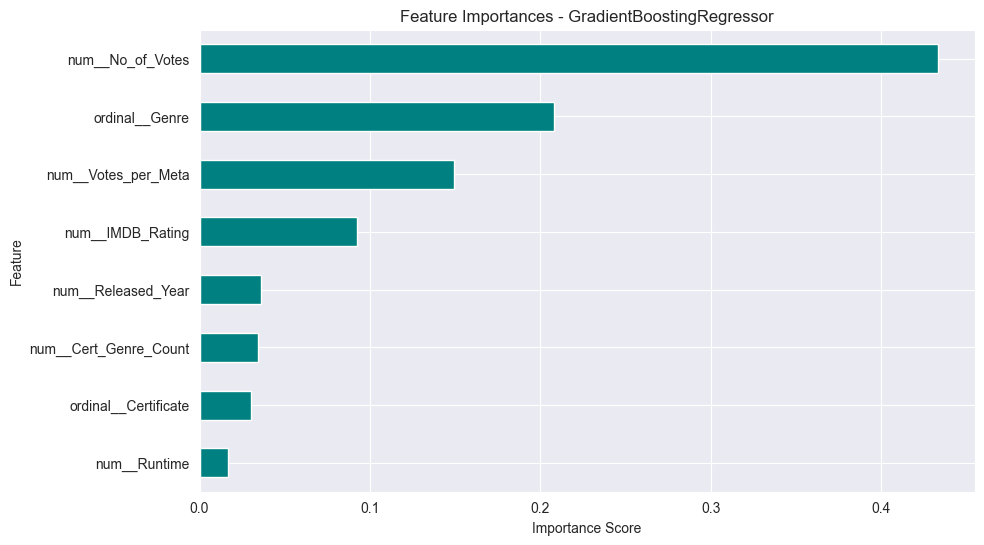

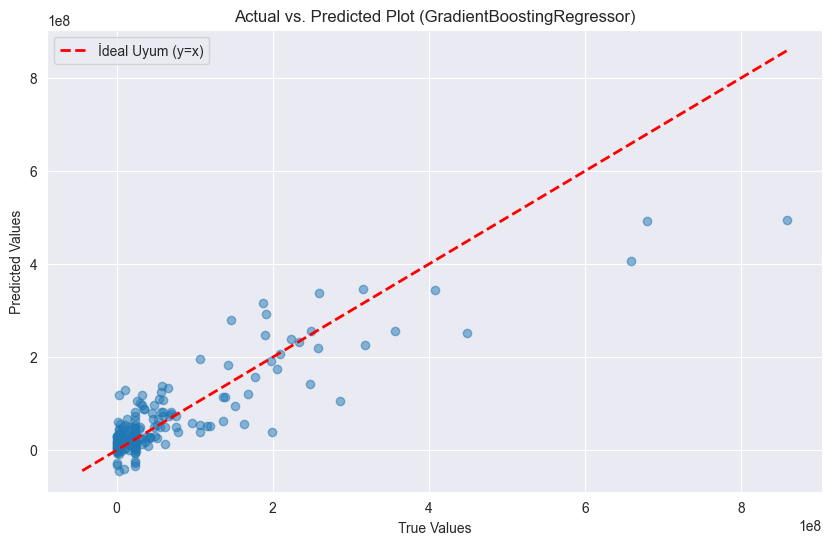

In [3]:
# PREDICT GROSS WITH GradientBoostingRegressor

from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

df["Votes_per_Meta"] = df["No_of_Votes"] / (df["Meta_score"] + 1)
df["Cert_Genre_Count"] = df.groupby(["Genre", "Certificate"], observed=True)["Certificate"].transform("count") # Veri setini aynı Tür ve aynı Sertifika kombinasyonuna göre gruplar / bu kombinasyondan kaç tane olup olmadığı sayılır

X = df[
    [
        "Released_Year", "Runtime", "IMDB_Rating", "No_of_Votes", "Votes_per_Meta", "Cert_Genre_Count", "Genre", "Certificate"
    ]
]
y = df["Gross"]

numeric_cols = ["Released_Year", "Runtime", "IMDB_Rating", "No_of_Votes", "Votes_per_Meta", "Cert_Genre_Count"]
categorical_cols = ["Genre", "Certificate"]

preprocess = ColumnTransformer(
    transformers=[
        ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)
model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        (
            "gb", GradientBoostingRegressor(
                n_estimators=200,
                max_depth=2, # değeri arttırılınca overfitting artıyor ve R² değeri düşüyor
                learning_rate=0.1,
                random_state=42
            )
        )
    ]
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("\nGradientBoostingRegressor R²:", round(r2_score(y_test, y_pred), 2))
print("RMSE:", round(rmse, 2))

# Feature Importances
rf = model.named_steps["gb"]
feature_names = model.named_steps["preprocess"].get_feature_names_out()

importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values()

plt.figure(figsize=(10, 6))
importances.plot(kind="barh", color="teal")
plt.title("Feature Importances - GradientBoostingRegressor")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Actual vs. Predicted Plot Graph
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)

# Veri aralığını belirleme
max_val = max(np.max(y_test), np.max(y_pred))
min_val = min(np.min(y_test), np.min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='İdeal Uyum (y=x)')

plt.title("Actual vs. Predicted Plot (GradientBoostingRegressor)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()


HistGradientBoostingRegressor R²: 0.721
RMSE: 60886743.14


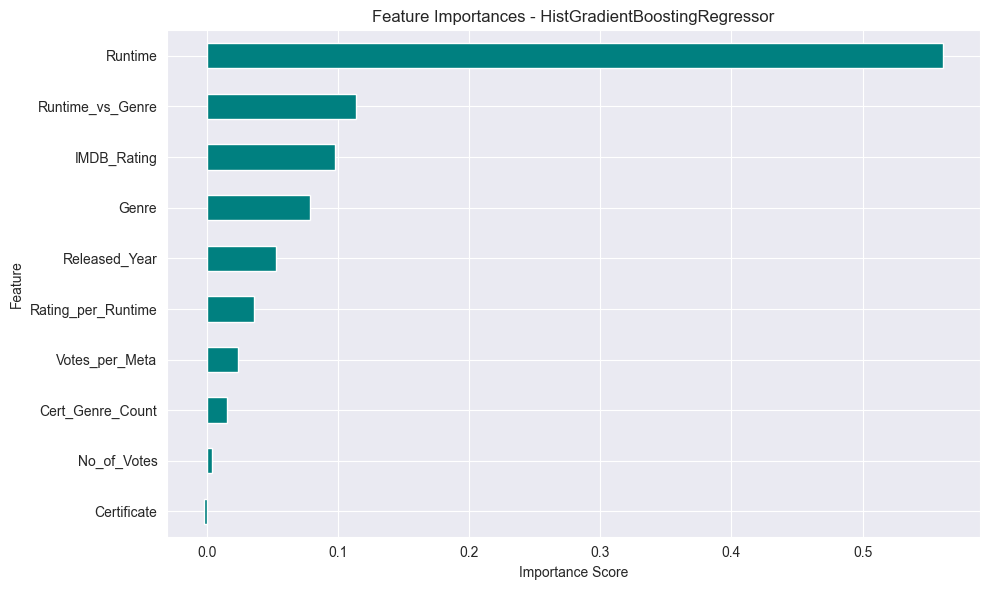

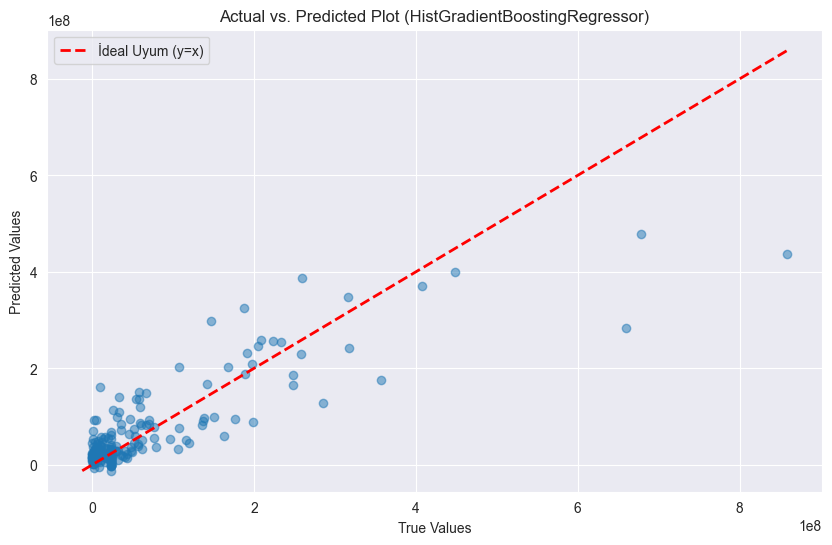

In [4]:
# PREDICT GROSS WITH HistGradientBoostingRegressor

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance

df["Votes_per_Meta"] = df["No_of_Votes"] / (df["Meta_score"] + 1) # oylar meta’ya göre normalleştirilir
df["Cert_Genre_Count"] = df.groupby(["Genre", "Certificate"], observed=True)["Certificate"].transform("count")
df["Genre_Avg_Runtime"] = df.groupby("Genre", observed=True)["Runtime"].transform("mean")
df["Runtime_vs_Genre"] = df["Runtime"] - df["Genre_Avg_Runtime"]
df["Rating_per_Runtime"] = df["IMDB_Rating"] / (df["Runtime"] + 1)

X = df[
    [
        "Released_Year", "Runtime", "IMDB_Rating", "No_of_Votes",
        "Votes_per_Meta", "Cert_Genre_Count", "Runtime_vs_Genre", "Rating_per_Runtime",
        "Genre", "Certificate"
    ]
]
y = df["Gross"]

numeric_cols = [
    "Released_Year", "Runtime", "IMDB_Rating", "No_of_Votes", "Votes_per_Meta", "Cert_Genre_Count", "Runtime_vs_Genre", "Rating_per_Runtime"
]
categorical_cols = ["Genre", "Certificate"]

preprocess = ColumnTransformer(
    transformers=[
        ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        (
            "hgb", HistGradientBoostingRegressor(
                max_depth=2,
                random_state=42
            )
        )
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(
    "\nHistGradientBoostingRegressor R²:",
    round(r2_score(y_test, y_pred), 3)
)
print("RMSE:", round(rmse, 2))

# Feature Importances
r = permutation_importance(
    model,
    X_test,
    y_test,
    n_repeats=5,
    random_state=42,
    scoring='r2'
)

# İsim Temizliği: 'num__Runtime' gibi ön ekleri kaldırıyoruz
raw_names = model.named_steps["preprocess"].get_feature_names_out()
clean_names = [name.split('__')[-1] for name in raw_names]

# Sonuçları ortalama düşüş değerine göre bir pd.Series'e dönüştür ve sırala
sorted_importances = pd.Series(
    r.importances_mean,
    index=clean_names
).sort_values()

plt.figure(figsize=(10, 6))
sorted_importances.plot(kind="barh", color="teal")
plt.title("Feature Importances - HistGradientBoostingRegressor")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Actual vs. Predicted Plot Graph
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)

# Veri aralığını belirleme
max_val = max(np.max(y_test), np.max(y_pred))
min_val = min(np.min(y_test), np.min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='İdeal Uyum (y=x)')

plt.title("Actual vs. Predicted Plot (HistGradientBoostingRegressor)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()